# Informer Demo

## Download code and dataset

In [1]:
!rm -rf Informer2020/
!git clone https://gitlab.com/oldajith/Informer2020.git
# !git clone https://gitlab.com/zhouhaoyi/Informer2020.git
# !git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 607, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 607 (delta 0), reused 0 (delta 0), pack-reused 603
Receiving objects: 100% (607/607), 6.49 MiB | 24.51 MiB/s, done.
Resolving deltas: 100% (347/347), done.
Informer2020  sample_data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [ ]:
# !pip install -r ./Informer2020/requirements.txt

## Experiments: Train and Test

In [4]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer as Exp
import torch, numpy as np

In [12]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = './drive/MyDrive/challenge/jobathon/data/' # root path of data file
args.data_path = 'energy.csv' # data file
args.data_path_test = 'energy_test.csv' # data file
args.validation_split = 0.1
args.features = 'S' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'energy' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length

args.inverse = False
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 1 # encoder input size
args.dec_in = 1 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


## Custom Data

Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.


In [6]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os

In [8]:
# custom data: xxx.csv
args.root_path = './drive/MyDrive/challenge/jobathon/data/'
args.data_path = 'energy.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [9]:
'''
We set 'HULL' as target instead of 'OT'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

args.target = 'energy'
args.freq = 'h'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = False; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path_test,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

shape of csv file loaded : (26400, 3)


In [10]:
batch_x,batch_y,batch_x_mark,batch_y_mark = data_set[-1]

In [11]:
batch_x

array([], shape=(0, 1), dtype=float64)

In [ ]:
len(data_set)

26281

In [13]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [ ]:
# # Set augments by using data name
# data_parser = {
#     'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
#     'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
#     'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
#     'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
# }
# if args.data in data_parser.keys():
#     data_info = data_parser[args.data]
#     args.data_path = data_info['data']
#     args.target = data_info['T']
#     args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [14]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [15]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': './drive/MyDrive/challenge/jobathon/data/', 'data_path': 'energy.csv', 'data_path_test': 'energy_test.csv', 'validation_split': 0.1, 'features': 'S', 'target': 'energy', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'inverse': False, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [16]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
shape of csv file loaded : (94992, 3)
train 85374
shape of csv file loaded : (94992, 3)
val 9476
shape of csv file loaded : (26400, 3)
test 26281
	iters: 100, epoch: 1 | loss: 0.2242173
	speed: 0.1313s/iter; left time: 2088.1024s
	iters: 200, epoch: 1 | loss: 0.1660705
	speed: 0.0691s/iter; left time: 1092.7559s
	iters: 300, epoch: 1 | loss: 0.1509743
	speed: 0.0695s/iter; left time: 1091.1413s
	iters: 400, epoch: 1 | loss: 0.1076033
	speed: 0.0700s/iter; left time: 1091.5917s
	iters: 500, epoch: 1 | loss: 0.0857629
	speed: 0.0702s/iter; left time: 1088.1328s
	iters: 600, epoch: 1 | loss: 0.1002450
	speed: 0.0708s/iter; left time: 1090.6946s
	iters: 700, epoch: 1 | loss: 0.0929977
	speed: 0.0711s/iter; left time: 1088.2768s
	iters: 800, epoch: 1 | loss: 0.1046979
	speed: 0.0714s/iter; left time: 1085.9941s
	iters: 900, epoc

In [ ]:
test_data, test_loader = exp._get_data(flag='test')      
exp.model.eval()

preds = []
trues = []

for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
    pred, true = exp._process_one_batch(
        test_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
    preds.append(pred.detach().cpu().numpy())
    trues.append(true.detach().cpu().numpy())

preds = np.vstack(preds)
trues = np.vstack(trues)
print('test shape:', preds.shape, trues.shape)

print('test shape:', preds.shape, trues.shape)


shape of csv file loaded : (26400, 3)


TypeError: ignored

## Prediction

In [ ]:
import os

# set saved model path
setting = 'informer_custom_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [ ]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

exp.predict(setting, True)

Use GPU: cuda:0


TypeError: ignored

In [ ]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

(1, 24, 1)

## Visualization

In [17]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)
import numpy as np
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((26281, 24, 1), (26281, 24, 1))

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
trues[0].shape

(24, 1)

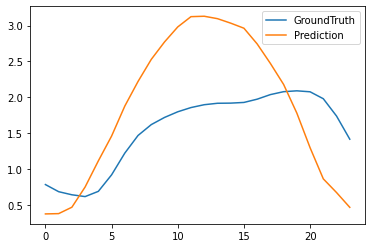

In [20]:
# draw OT prediction
plt.figure()
plt.plot(trues[1,:,-1], label='GroundTruth')
plt.plot(preds[4,:,-1], label='Prediction')
plt.legend()
plt.show()

In [ ]:
trues[-1]

array([[26280.],
       [26281.],
       [26282.],
       [26283.],
       [26284.],
       [26285.],
       [26286.],
       [26287.],
       [26288.],
       [26289.],
       [26290.],
       [26291.],
       [26292.],
       [26293.],
       [26294.],
       [26295.],
       [26296.],
       [26297.],
       [26298.],
       [26299.],
       [26300.],
       [26301.],
       [26302.],
       [26303.]], dtype=float32)

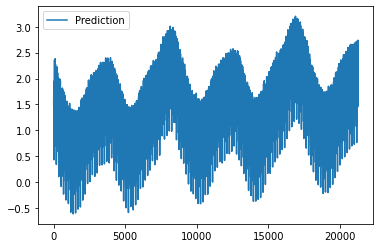

In [21]:
# draw HUFL prediction
plt.figure()
# plt.plot(trues[:,0,0], label='GroundTruth')
plt.plot(preds[5000:,0,0], label='Prediction')
plt.legend()
plt.show()

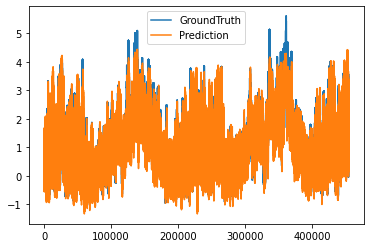

In [ ]:
# draw whole prediction - saved during inital training
plt.figure()
plt.plot(trues.ravel(), label='GroundTruth')
plt.plot(preds.ravel(), label='Prediction')
plt.legend()
plt.show()

In [ ]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)


In [ ]:
def predict(exp):
    pred_data, pred_loader = data_set,data_loader

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])

    return preds

preds = predict(exp)

In [ ]:
preds

array([[[ 0.7782012 ],
        [ 0.44336545],
        [ 0.20349671],
        [-0.03758508],
        [-0.1018635 ],
        [-0.02143604],
        [ 0.209943  ],
        [ 0.46837997],
        [ 0.7433898 ],
        [ 1.0456    ],
        [ 1.4021558 ],
        [ 1.7210373 ],
        [ 2.0114594 ],
        [ 2.2775154 ],
        [ 2.5089016 ],
        [ 2.5884786 ],
        [ 2.7332025 ],
        [ 2.7653475 ],
        [ 2.69179   ],
        [ 2.5821815 ],
        [ 2.4725184 ],
        [ 2.32897   ],
        [ 2.0362735 ],
        [ 1.7410332 ]]], dtype=float32)

#Create Submission file

In [ ]:
train_data = pd.read_csv("data//train_IxoE5JN.csv",index_col='row_id')
test_data = pd.read_csv("data//test_WudNWDM.csv",index_col='row_id')

# %% fill missing values
print('NaN values - ')
print(f'before : {sum(pd.isna(train_data.energy))}')
train_data['energy'] = (train_data.energy.fillna(method='ffill')+train_data.energy.fillna(method='bfill'))/2
print(f'after : {sum(pd.isna(train_data.energy))}')#print length of missing values

energy = train_data[['datetime','energy']].rename(columns={'datetime':'date'})
energy_test = test_data[['datetime']].rename(columns={'datetime':'date'})

In [ ]:
Y = energy.energy.rolling(24*365, min_periods=24*30, center=False, win_type=None, axis=0).mean().dropna()
x,y = Y.index.values.reshape(-1,1), Y.values
# %%
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x, y)
print(reg.score(x, y),reg.coef_)
x_fut = np.arange(94993,121297).reshape(-1,1)
y_fut = reg.predict(x_fut)


In [ ]:
test_data['y_mean'] = y_fut
# %%
pred = np.load('pred.npy')
y_informer = np.hstack([pred[:,0,0].reshape(-1),pred[-1,1:,0].reshape(-1)])
test_data['y_informer'] = y_informer
y_ene_test_std = y_informer*energy_test.energy.std(0)+y_fut
y_ene_std = y_informer*energy.energy.std(0)+y_fut
test_data['energy_test_std'] = y_ene_test_std
test_data['energy_std'] = y_ene_std

In [ ]:
test_data['energy'] = test_data['energy_std']
submission = test_data[['energy']]
submission.to_csv('submission.csv')